In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import bilby
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from src import optimise_matched_filter, matched_filter_optimised

# Set Plotting Style
mpl.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "text.usetex": False,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
})

## **Load the Relevent Data**
- PSD
- Strain
- Waveform

In [24]:
# In the question we are given the sampling frequency, duration of the segment, and GPS start time.
sampling_frequency = 2048 # Hz
duration = 4 # seconds
gps_start_time = 1126259460.4 # seconds

# Create time array
num_samples = int(duration * sampling_frequency)
time_array = gps_start_time + np.arange(num_samples) / sampling_frequency
plot_time = time_array - gps_start_time

# Print the length of the time array and the start and end times
print(f"Time array length: {len(time_array)}")
print(f"Start time: {time_array[0]}")
print(f"End time: {time_array[-1]}")

# --- Load PSDs for each detector ---
H1_f_psd, H1_Sn = np.loadtxt("data/H1/H1_psd.txt", unpack=True)
L1_f_psd, L1_Sn = np.loadtxt("data/L1/L1_psd.txt", unpack=True)
V1_f_psd, V1_Sn = np.loadtxt("data/V1/V1_psd.txt", unpack=True)

# --- Load strain data for each detector ---
H1_f, H1_real, H1_imag  = np.loadtxt("data/H1/H1_strain.txt", unpack=True)
L1_f, L1_real, L1_imag  = np.loadtxt("data/L1/L1_strain.txt", unpack=True)
V1_f, V1_real, V1_imag  = np.loadtxt("data/V1/V1_strain.txt", unpack=True)

# Combine the values into complex arrays
H1_strain = H1_real + 1j * H1_imag
L1_strain = L1_real + 1j * L1_imag
V1_strain = V1_real + 1j * V1_imag

# --- Load waveform template ---
f_wave, hplus_real, hplus_imag, hcross_real, hcross_imag = np.loadtxt("data/Waveform/waveform.txt", unpack=True)
h_plus = hplus_real + 1j * hplus_imag
h_cross = hcross_real + 1j * hcross_imag

Time array length: 8192
Start time: 1126259460.4
End time: 1126259464.3995118


## **Joint Likelihood (Multiple Interferometers)**

$$
\mathcal{L}(\text{data}{\mathrm{IFO1}}, \text{data}{\mathrm{IFO2}}, \ldots \mid D_L, \text{RA}, \text{Dec}, \psi, t_c^{(\mathrm{geo})})
$$

## **For a Single Interferometer**

$$
\mathcal{L}(\text{data}_{\mathrm{IFO}} \mid D_L, \text{RA}, \text{Dec}, \psi, t_c^{(\mathrm{geo})})
$$

---

### **Time Series Data**

- Given a strain time series: $d(t)$
- Its Fourier transform $\tilde{d}(f)$

⸻

### **Noise-Only Model**

Under the noise hypothesis H_{\text{noise}}, the Fourier domain noise components are assumed to be Gaussian-distributed with variance given by the one-sided PSD S_n(f). The likelihood becomes:

$$
\rho(n \mid H_{\text{noise}})
= \prod_{i=0}^{N} \rho(\tilde{n}(f_i) \mid H_{\text{noise}})
= \mathcal{N} \exp\left( -\frac{1}{2} \sum_{i=0}^{N} \frac{|\tilde{n}(f_i)|^2}{S_n(f_i)} \right)
= \mathcal{N} \exp\left( -\frac{(n|n)}{2} \right)
$$

⸻

### **Waveform Model**

The detector-frame waveform is given by:

$$
\tilde{h}{_\text{det}}(f) = F_+(f) \tilde{h}_+(f) + F_\times(f) \tilde{h}_\times(f)
$$

- where $F_+(f)$ and $F_\times(f)$ are the antenna responses dependent on the RA, DEC, PSI and $t_\text{geo}$.

$$
t_\text{detector} = t_\text{geo} + t_\text{delay}
$$

- where the time coalecence is set to default as $t_\text{detector} = 0$

### **Time Translation**

To shift the waveform in time by $\tau$, apply:

$$
h(t + \tau) \xrightarrow{\mathcal{F}} \tilde{h}(f) e^{2\pi i f \tau_\text{detector}}
$$

### **Luminosity Distance Scaling**

If the waveform was originally simulated at $D_L = 1$ Gpc, rescale to arbitrary distance:

$$
\tilde{h}{_\text{det}}(f; D_L) = \left( \frac{1  \text{Gpc}}{D_L} \right) \tilde{h}{_\text{det}}(f)
$$

⸻

### **Likelihood Under Signal Hypothesis**

We assume the signal model:
$$
d(t) = n(t) + h_{\vec{\theta}}(t)
$$


$$
\mathcal{L}(d, \vec{\theta}) = \mathcal{P}(d \mid \vec{\theta}, H_{\text{signal}}) = \mathcal{P}(d - h_{\vec{\theta}} \mid H_{\text{noise}})
$$

$$
\mathcal{L}(d, \vec{\theta}) = \mathcal{N} \exp\left( - \frac{ \langle d - h_{\vec{\theta}} | d - h_{\vec{\theta}} \rangle }{2} \right)
= \mathcal{N} \exp\left( -\frac{1}{2} \sum_{i=0}^{N} \frac{|\tilde{d}(f_i) - \tilde{h}_{\vec{\theta}}(f_i)|^2}{S_n(f_i)} \right)
$$

$$
\log \mathcal{L}(d \mid \vec{\theta}) \propto -\frac{1}{2} \sum_{i=0}^{N_f - 1} \frac{|\tilde{d}(f_i) - \tilde{h}_{\vec{\theta}}(f_i)|^2}{S_n(f_i)}
$$

---


## **Going back to multiple interferometer likelihood**

$$
\{d_i\}_{\mathcal{I}=1}^{N_{\text{det}}}:\quad
\mathcal{P}(\{d_i\} \mid \vec{\theta}) = \prod_{\mathcal{I}} \mathcal{P}(d_{\mathcal{I}} \mid \vec{\theta}) 
\propto \exp\left( -\sum_{\mathcal{I}} \frac{\langle d_{\mathcal{I}} - h_{\vec{\theta}} \mid d_{\mathcal{I}} - h_{\vec{\theta}} \rangle}{2} \right)
$$

$$
\log \mathcal{L}(\{d_i\} \mid \vec{\theta}) 
\propto 
- \frac{1}{2} \sum_{\mathcal{I}=1}^{N_{\text{det}}} \sum_{i=0}^{N_f - 1} 
\frac{|\tilde{d}_{\mathcal{I}}(f_i) - \tilde{h}_{\vec{\theta},\mathcal{I}}(f_i)|^2}{S_n^{(\mathcal{I})}(f_i)}
$$

## **Effect of Waveforms**
- Before coding up the likelihood we just verify that the tranformations (for time shift and $D_l$ are valid). 


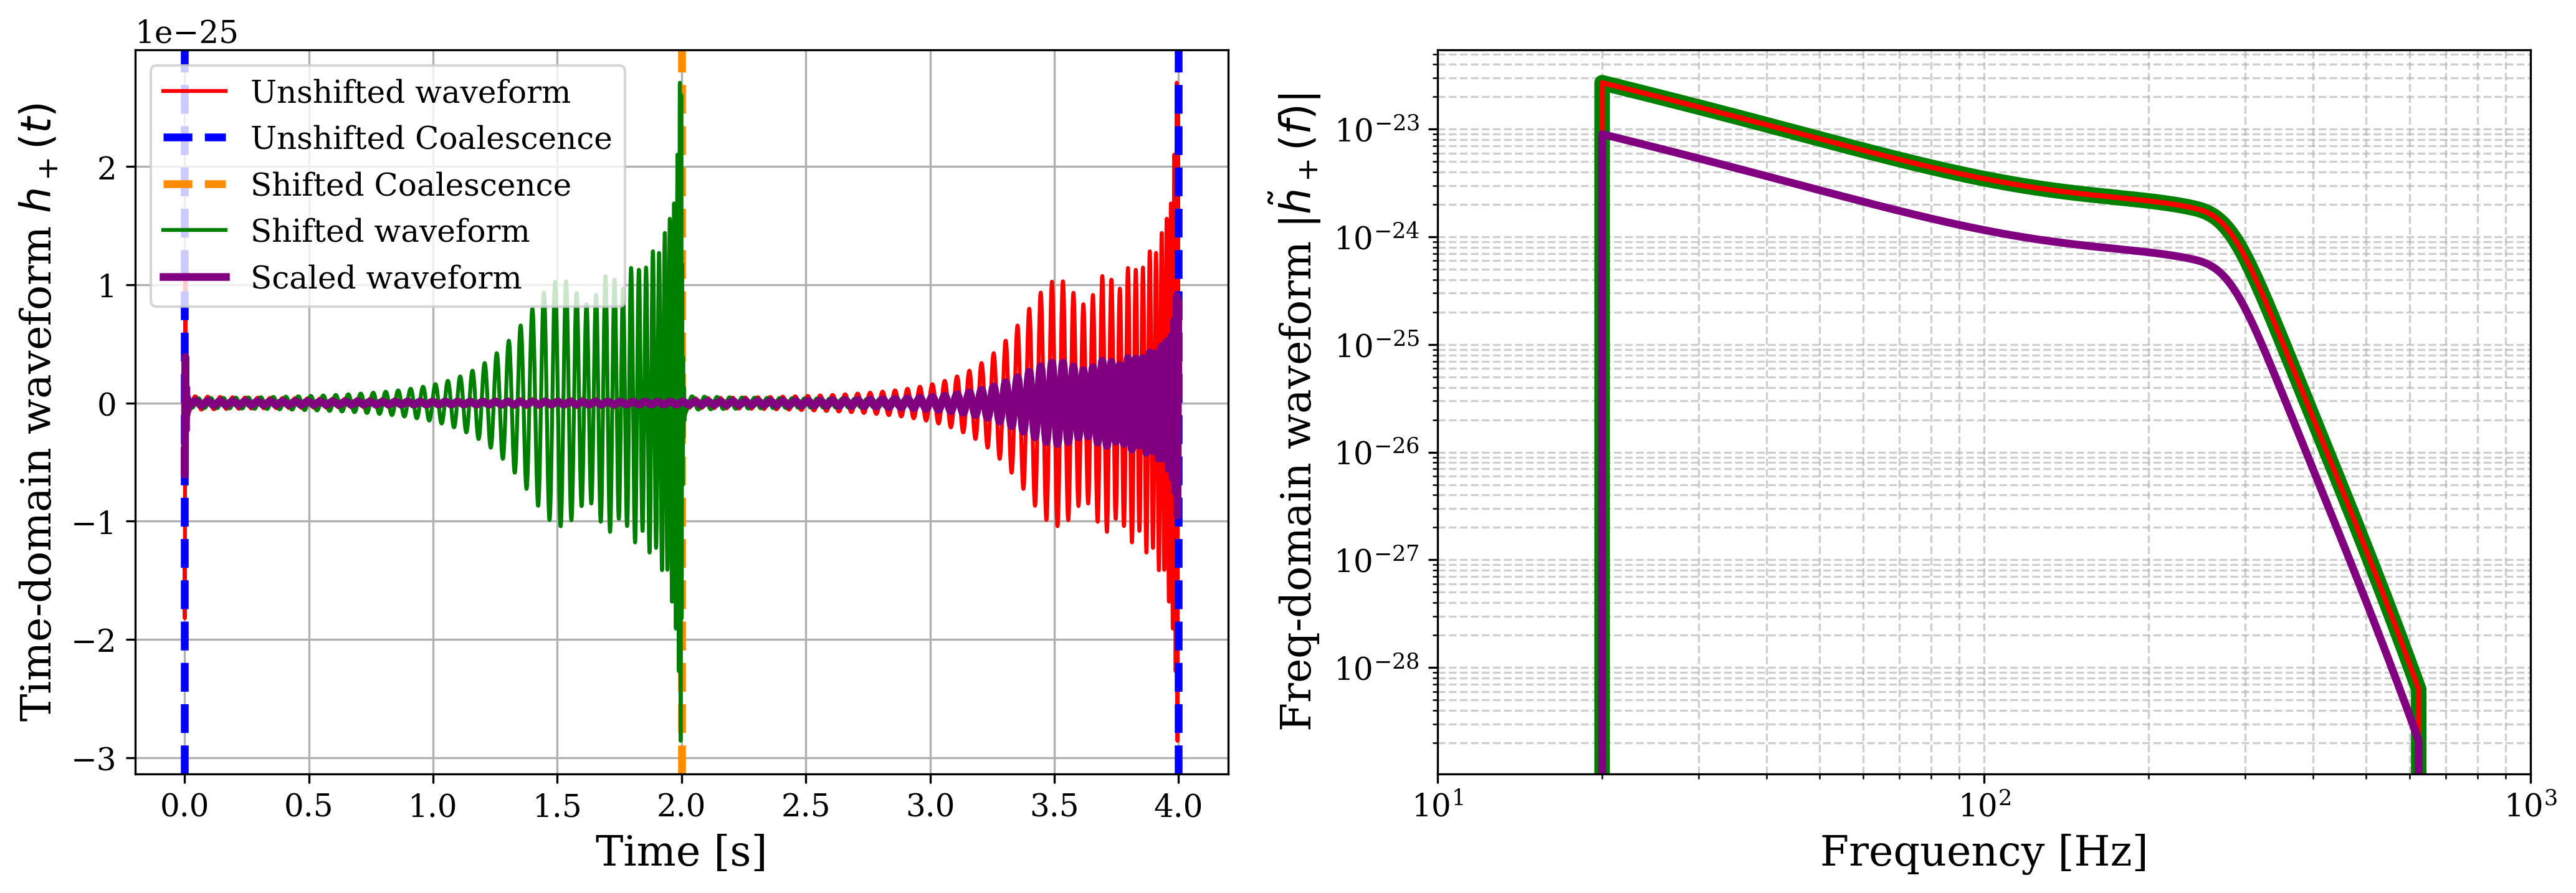

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Tranformation under the a time shift of 2 seconds
h_plus_shifted = h_plus * np.exp(-2j * np.pi * f_wave * 2)
# Scaled by 1/Dl - Double the distance to 3 Gpc
h_plus_scaled = h_plus / 3

# --- Time-domain plot ---
h_plus_time = np.fft.irfft(h_plus)
h_plus_time_shifted = np.fft.irfft(h_plus_shifted)
h_plus_time_scaled = np.fft.irfft(h_plus_scaled)

# Plot the unshifted waveform
axs[0].plot(plot_time, h_plus_time, color='red', label="Unshifted waveform")
axs[0].axvline(plot_time[0], color='blue', linestyle='--', linewidth=3, label="Unshifted Coalescence")
axs[0].axvline(plot_time[-1], color='blue', linestyle='--', linewidth=3)

# Plot the shifted waveform
axs[0].axvline(plot_time[0] + 2, color='darkorange', linestyle='--', linewidth=3, label="Shifted Coalescence")
axs[0].plot(plot_time, h_plus_time_shifted, color='green', label="Shifted waveform")

# Plot the scaled waveform
axs[0].plot(plot_time, h_plus_time_scaled, color='purple', linewidth=3, label="Scaled waveform")

axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'Time-domain waveform $h_+(t)$')
axs[0].legend(loc ='upper left')
axs[0].grid(True)

# --- Frequency-domain plot ---
# Plot the shifted waveform
axs[1].loglog(f_wave, np.abs(h_plus_shifted), color='green', linewidth=6, label="Shifted waveform")
# Plot the unshifted waveform
axs[1].loglog(f_wave, np.abs(h_plus), color='red', linewidth=2, label="Unshifted waveform")
# Plot the scaled waveform
axs[1].loglog(f_wave, np.abs(h_plus_scaled), color='purple', linewidth=3, label="Scaled waveform")


axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel(r'Freq-domain waveform $|\tilde{h}_+(f)|$')
axs[1].set_xlim(10, 1000)
axs[1].grid(True, which='both', ls='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [53]:
# Creating the overall likelihood function,
def overall_likelihood(detector, detector_strain, detector_psd, freq_array, waveform_h_plus, waveform_h_cross, ra, dec, psi, t_geo, Dl):
    """
    Compute the log-likelihood of a gravitational wave signal given a sky location, 
    polarization angle, coalescence time, and luminosity distance for a single detector.

    Parameters
    ----------
    detector : str
        The detector name, must be one of 'H1', 'L1', or 'V1'.
    detector_strain : array-like
        The observed strain data in the frequency domain for the detector.
    detector_psd : array-like
        The one-sided power spectral density (PSD) of the detector.
    freq_array : array-like
        Array of frequencies corresponding to the Fourier components.
    waveform_h_plus : array-like
        Frequency-domain gravitational wave strain for the plus polarization (at 1 Gpc).
    waveform_h_cross : array-like
        Frequency-domain gravitational wave strain for the cross polarization (at 1 Gpc).
    ra : float
        Right ascension of the source in radians.
    dec : float
        Declination of the source in radians.
    psi : float
        Polarization angle in radians.
    t_geo : float
        Time of coalescence at the geocenter (GPS time).
    Dl : float
        Luminosity distance to the source in Gpc.

    Returns
    -------
    log_likelihood : float
        The log-likelihood of the observed data given the signal model at this sky location.
    """

    # Ensure that only two detectors are named and they are either H1, L1 or V1
    if detector not in ['H1', 'L1', 'V1']:
        raise ValueError("Detector must be one of 'H1', 'L1', or 'V1'.")
    
    # Intialise the bilby interferometer object
    Inter_obj = bilby.gw.detector.InterferometerList([detector])[0]
    # Calculate the time delay from the geocenter
    time_delay = Inter_obj.time_delay_from_geocenter(ra=ra, dec=dec, time=t_geo)
    
    # Calculate the expected arrival time at the detector
    detector_arrival_time = t_geo + time_delay

    # Calculate the antenna response for the given RA, Dec, and Psi
    Fplus = Inter_obj.antenna_response(ra, dec, detector_arrival_time, psi, 'plus')
    Fcross = Inter_obj.antenna_response(ra, dec, detector_arrival_time, psi, 'cross')

    # Calculate the expected strain at the detector - no fourier shift
    # Amplitude is affected by the distance to the source (1Gpc/Dl)
    expected_strain = (Fplus * waveform_h_plus + Fcross * waveform_h_cross)/Dl 

    # With a time shift - using fourer transform property
    transformed_expected_strain = expected_strain * np.exp(-2j * np.pi * freq_array * detector_arrival_time)

    # The residual strain is the difference between the detector strain and the expected strain
    residual_strain = detector_strain - transformed_expected_strain

    # Using a gaussian likelihood model
    log_likelihood = - np.sum(np.real(residual_strain * np.conj(residual_strain) / detector_psd))

    return log_likelihood


def H1_likelihood(ra, dec, psi, t_geo, Dl):
    """
    Likelihood function for the H1 detector.
    """
    return overall_likelihood('H1', H1_strain, H1_Sn, H1_f_psd, h_plus, h_cross, ra, dec, psi, t_geo, Dl)

def L1_likelihood(ra, dec, psi, t_geo, Dl):
    """
    Likelihood function for the L1 detector.
    """
    return overall_likelihood('L1', L1_strain, L1_Sn, L1_f_psd, h_plus, h_cross, ra, dec, psi, t_geo, Dl)

def V1_likelihood(ra, dec, psi, t_geo, Dl):
    """
    Likelihood function for the V1 detector.
    """
    return overall_likelihood('V1', V1_strain, V1_Sn, V1_f_psd, h_plus, h_cross, ra, dec, psi, t_geo, Dl)

def overall_likelihood_all(ra, dec, psi, t_geo, Dl):
    """
    Combined likelihood function for all detectors.
    """
    return H1_likelihood(ra, dec, psi, t_geo, Dl) + L1_likelihood(ra, dec, psi, t_geo, Dl) + V1_likelihood(ra, dec, psi, t_geo, Dl)


In [54]:
overall_likelihood('H1', H1_strain, H1_Sn, H1_f, h_plus, h_cross, ra=0.0, dec=0.0, psi=0.0, t_geo=0, Dl=1)

np.float64(-8797.17261048816)

In [43]:
H1_likelihood(ra=0.0, dec=0.0, psi=0.0, t_geo=gps_start_time, Dl=1)

np.float64(-8800.422751075293)